# H1N1 Vaccines Model Analysis

As the world struggles to vaccinate the global population against COVID-19, an understanding of how people’s backgrounds, opinions, and health behaviors are related to their personal vaccination patterns can provide guidance for future public health efforts. Your audience could be someone guiding those public health efforts.

This challenge: can you predict whether people got H1N1 and seasonal flu vaccines using data collected in the National 2009 H1N1 Flu Survey? This is a binary classification problem, but there are two potential targets: whether the survey respondent received the seasonal flu vaccine, or whether the respondent received the H1N1 flu vaccine. Please choose just one of these potential targets for your minimum viable project.

The goal is to predict how likely individuals are to receive their H1N1 and seasonal flu vaccines.

Let's start with our imports, and then load in the data. I pulled the datasets from the competition website, linked here: https://www.drivendata.org/competitions/66/flu-shot-learning/data/. I will repull them in here in case I mixed something up in the general analysis (I want to avoid data leakage). 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures

from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.metrics import classification_report

In [2]:
# load in the training set features file, set the index column equal to respondent id.
training_features = pd.read_csv('../Data/training_set_features.csv', index_col='respondent_id')
training_features.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [3]:
# load in the training set labels file, set the index column equal to respondent id.
training_labels = pd.read_csv('../Data/training_set_labels.csv', index_col='respondent_id')
training_labels.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [4]:
training_features.shape

(26707, 35)

In [5]:
training_labels.shape

(26707, 2)

I remember from my data analysis that hhs_geo_region, employment_industry, and employment_occupation are random strings. I don't see how I am going to be able to use these as I can't make sense of them, so I am just going to drop them. 

In [6]:
training_features[['hhs_geo_region', 'employment_industry', 'employment_occupation']].head()

,hhs_geo_region,employment_industry,employment_occupation
respondent_id,,,
0,oxchjgsf,NaN,NaN
1,bhuqouqj,pxcmvdjn,xgwztkwe
2,qufhixun,rucpziij,xtkaffoo
3,lrircsnp,NaN,NaN
4,qufhixun,wxleyezf,emcorrxb


In [7]:
training_features.drop(columns=['hhs_geo_region', 'employment_industry', 'employment_occupation'], axis=1, inplace=True)

In [8]:
training_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [9]:
training_features.shape

(26707, 32)

Let's move on. If I find I need to drop more columns during the model building process, I will come back and do so. 

### Setting our target/features and the train-test-split

This dataset comes with two possible targets. As we only need to pick one, I decided on H1N1 vaccine (see the full process in the general EDA notebook). 

Let's set our variables and then do our train-test-split. 

In [10]:
X = training_features
y = training_labels.drop('seasonal_vaccine', axis=1)

In [11]:
# confirming everything is there
X.head(2)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,Non-MSA,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,"MSA, Not Principle City",0.0,0.0


In [12]:
# confirming everything is there
y.head(2)

,h1n1_vaccine
respondent_id,
0,0
1,0


In [13]:
# now do the train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print('\n')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (20030, 32)
y_train: (20030, 1)


X_test: (6677, 32)
y_test: (6677, 1)


The shapes match up with the train and test sets, so this looks good. We're going to leave the test set alone until we're ready to validate. Let's look at X_train. 

In [15]:
X_train.isna().sum().sort_values(ascending=False)

health_insurance               9233
income_poverty                 3269
doctor_recc_h1n1               1635
doctor_recc_seasonal           1635
rent_or_own                    1512
employment_status              1081
education                      1040
marital_status                 1038
chronic_med_condition           717
child_under_6_months            605
health_worker                   597
opinion_seas_sick_from_vacc     407
opinion_seas_risk               387
opinion_seas_vacc_effective     349
opinion_h1n1_sick_from_vacc     301
opinion_h1n1_vacc_effective     299
opinion_h1n1_risk               292
household_children              188
household_adults                188
behavioral_avoidance            157
behavioral_touch_face            98
h1n1_knowledge                   87
behavioral_large_gatherings      70
h1n1_concern                     67
behavioral_outside_home          58
behavioral_antiviral_meds        56
behavioral_wash_hands            36
behavioral_face_mask        

To organize myself before diving into pipelines, let's make a list of everything to do. 

1. Train-test-split (done!)
2. Set numerical and categorical columns. 
3. Explore those columns and determine what needs to be done (scaling, simple imputer, ohe/ordinal, polynomials? lasso/ridge?)
4. Build the sub-pipes. 
5. Put them through the column transformer. 
6. Build a dummy/baseline model. 
7. Build a first simple model and evaluate (confusion matrix, check scores, precision, accuracy, recall, etc.)
8. Grid search and hyperparameter tuning!

Borrowing code from phase 3, lecture 41-classification_workflow, to save the different model results, cross validate, and print the results (might remove the plot). 

In [16]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)
        
        
    def plot_cv(self, ax):
        ax.set_title(f'CV Results for `{self.name}` Model')

        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax)

        return ax

### Building the pipeline

Let's set numerical and categorical columns. There are no true numerical columns in this dataset. Everything that is a float is either binary or ordinal. We can put both through the simple imputer using the most frequent value. I'm not sure if simple imputer will impute on an individual column basis, or the entire thing, so let's create three sub-pipes: one for the binary columns, one for the ordinal columns, and one for the categorical columns. 

According to the data dictionary (found here: https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/) the following columns are ordinal and the rest of the numerical ones are binary: 

- h1n1_concern (ranks from 0-3)
- h1n1_knowledge (ranks from 0-2)
- opinion_h1n1_vacc_effective (ranks from 1-5)
- opinion_h1n1_risk (ranks from 1-5)
- opinion_h1n1_sick_from_vacc (ranks from 1-5)
- opinion_seas_vacc_effective (ranks from 1-5)
- opinion_seas_risk (ranks from 1-5)
- opinion_seas_sick_from_vacc (ranks from 1-5)

In [17]:
X_train.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

In [18]:
# select everything that is a numerical type
num_selector = selector(dtype_include=np.number)
num_cols = num_selector(X_train)
num_cols

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [19]:
# create the ordinal columns list using info from the data dictionary
ord_cols = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 
                'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 
                'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

# create the binary columns - if it's in the num_cols list
# and not in the ordinal columns list, add it to the binary_columns list
bin_cols = []
for col in num_cols:
    if col not in ord_cols:
        bin_cols.append(col)

# create the categorical columns
cat_selector = selector(dtype_include=object)
cat_cols = cat_selector(X_train)

In [20]:
bin_cols

['behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'household_adults',
 'household_children']

In [21]:
ord_cols

['h1n1_concern',
 'h1n1_knowledge',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc']

In [22]:
cat_cols

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'census_msa']

Now create the sub-pipes for binary, ordinal, and categorical, and put them through the column transformer. 

In [23]:
bin_pipe = Pipeline(steps=[
    ('bin_impute', SimpleImputer(strategy='most_frequent')), # try most frequent since we're doing categorical
])

ord_pipe = Pipeline(steps=[
    ('ord_impute', SimpleImputer(strategy='most_frequent'))
])

cat_pipe = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')), 
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [24]:
CT = ColumnTransformer(transformers=[
    ('bin_pipe', bin_pipe, bin_cols), 
    ('ord_pipe', ord_pipe, ord_cols),
    ('cat_pipe', cat_pipe, cat_cols) 
])

### Create a dummy baseline model

In [25]:
# let's use dummy classifier with strategy most frequent
# dummy classifier is good for binary classifications
# dummy regressor better for continuous targets

dummy_pipe = Pipeline(steps=[
    ('ct', CT), 
    ('dummy', DummyClassifier(strategy='stratified')) 
])

In [26]:
# fit it on the train set
dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('bin_pipe',
                                                  Pipeline(steps=[('bin_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1',
                                                   'doctor_recc_...
                                          

Let's look at the scores for train and test.

In [27]:
# score it
dummy_pipe.score(X_train, y_train)

0.6657014478282576

In [28]:
dummy_pipe.score(X_test, y_test)

0.6607757975138535

Let's print out the accuracy, precision, recall, and f1 scores from train and test.

In [29]:
# print out scores for
dummy_train_y_pred = dummy_pipe.predict(X_train)
dummy_test_y_pred = dummy_pipe.predict(X_test)

print(f"train accuracy: {round(accuracy_score(y_train, dummy_train_y_pred),4)}")
print(f"train precision: {round(precision_score(y_train, dummy_train_y_pred),4)}")
print(f"train recall: {round(recall_score(y_train, dummy_train_y_pred),4)}")
print(f"train f1: {round(f1_score(y_train, dummy_train_y_pred),4)}")
print(f"\n")
print(f"test accuracy: {round(accuracy_score(y_test, dummy_test_y_pred),4)}")
print(f"test precision: {round(precision_score(y_test, dummy_test_y_pred),4)}")
print(f"test recall: {round(recall_score(y_test, dummy_test_y_pred),4)}")
print(f"test f1: {round(f1_score(y_test, dummy_test_y_pred),4)}")

train accuracy: 0.6655
train precision: 0.2085
train recall: 0.2053
train f1: 0.2069


test accuracy: 0.666
test precision: 0.2131
test recall: 0.2131
test f1: 0.2131


In [30]:
# save the model
dummy_model_results = ModelWithCV(
    model=dummy_pipe,
    model_name = 'Dummy',
    X=X_train,
    y=y_train)

In [31]:
dummy_cross_val_score = dummy_model_results.cv_results
dummy_cross_val_score

array([0.67498752, 0.67898153, 0.64952571, 0.65851223, 0.66000999,
       0.65202197, 0.66350474, 0.67199201, 0.66150774, 0.66200699])

In [32]:
dummy_model_results.print_cv_summary()

CV Results for `Dummy` model:
            0.66331 ± 0.00902 accuracy
        


Let's plot a confusion matrix for train and test.

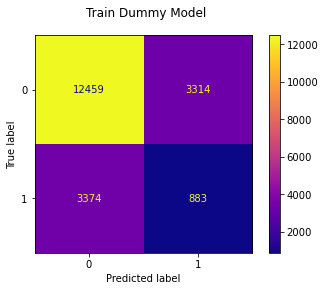

In [33]:
# confusion matrix
fig, ax = plt.subplots()
fig.suptitle('Train Dummy Model')
plot_confusion_matrix(dummy_pipe, X_train, y_train, ax=ax, cmap='plasma');

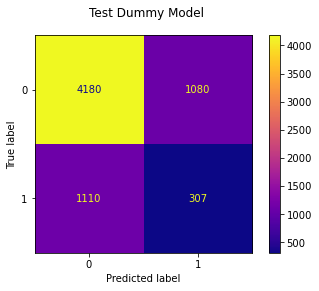

In [34]:
fig, ax = plt.subplots()
fig.suptitle('Test Dummy Model')
plot_confusion_matrix(dummy_pipe, X_test, y_test, ax=ax, cmap='plasma');

Let's plot ROC curves for train and test. 

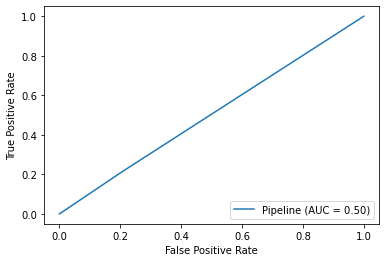

In [35]:
# roc curve
plot_roc_curve(dummy_pipe, X_train, y_train);

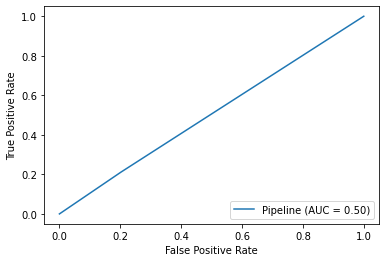

In [36]:
plot_roc_curve(dummy_pipe, X_test, y_test);

Our dummy model has 12,430 true negatives, 856 true positives, 3401 false negatives, and 3343 false positives. We also have an AUC of 0.50 which is just not great. We want to try and maximize true positives and minimize false positives with our next model. 

In [37]:
y_train.value_counts()

h1n1_vaccine
0               15773
1                4257
dtype: int64

Ok so: we have a baseline dummy model with a 66% accuracy, 21% precision, 21% recall, and 21% fl score. Our target is pretty imbalanced. This isn't great. For the first simple model, let's use SMOTE and the imbpipeline and see if we can do better. 

### First Simple Model - Logistic Regression

We need to use the ImPipeline to be able to use SMOTE, so let's create a new first simple model using that.

In [38]:
fsm_pipe = ImPipeline(steps=[
    ('ct', CT), # now this is where we SMOTE our data
    ('sm', SMOTE(sampling_strategy='auto', random_state=42)), 
    ('fsm', LogisticRegression())    
])

In [39]:
# I am getting a convergence warning when trying to use just y_train: 
# a column vector was passed when a 1d array was expected, try using ravel
# ravel will flatten the vector

fsm_pipe.fit(X_train, y_train.values.ravel())

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('bin_pipe',
                                                  Pipeline(steps=[('bin_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1',
                                                   'doctor_recc_...
                                          

In [40]:
y_train.value_counts()

h1n1_vaccine
0               15773
1                4257
dtype: int64

Smote is seeming to have no effect on the distribution. This seems imbalanced to me, I will come back to it later. 

Let's take the scores of both train and test. 

In [41]:
# score it
fsm_pipe.score(X_train, y_train)

0.7756365451822267

In [42]:
fsm_pipe.score(X_test, y_test)

0.7796914782087764

In [43]:
# print out scores
fsm_train_y_pred = fsm_pipe.predict(X_train)
fsm_test_y_pred = fsm_pipe.predict(X_test)

print(f"train accuracy: {round(accuracy_score(y_train, fsm_train_y_pred),4)}")
print(f"train precision: {round(precision_score(y_train, fsm_train_y_pred),4)}")
print(f"train recall: {round(recall_score(y_train, fsm_train_y_pred),4)}")
print(f"train f1: {round(f1_score(y_train, fsm_train_y_pred),4)}")
print(f"\n")
print(f"test accuracy: {round(accuracy_score(y_test, fsm_test_y_pred),4)}")
print(f"test precision: {round(precision_score(y_test, fsm_test_y_pred),4)}")
print(f"test recall: {round(recall_score(y_test, fsm_test_y_pred),4)}")
print(f"test f1: {round(f1_score(y_test, fsm_test_y_pred),4)}")

train accuracy: 0.7756
train precision: 0.4815
train recall: 0.7237
train f1: 0.5783


test accuracy: 0.7797
test precision: 0.4871
test recall: 0.717
test f1: 0.5801


In [44]:
# save the model
fsm_model_results = ModelWithCV(
    model=fsm_pipe,
    model_name = 'FSM',
    X=X_train,
    y=y_train.values.ravel())

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

In [45]:
fsm_cross_val_score = fsm_model_results.cv_results
fsm_cross_val_score

array([0.76135796, 0.76934598, 0.79281078, 0.76984523, 0.76784823,
       0.77184224, 0.77683475, 0.79181228, 0.7783325 , 0.77034448])

In [46]:
fsm_model_results.print_cv_summary()

CV Results for `FSM` model:
            0.77504 ± 0.00970 accuracy
        


Let's plot confusion matrices and ROC curves for both train and test.

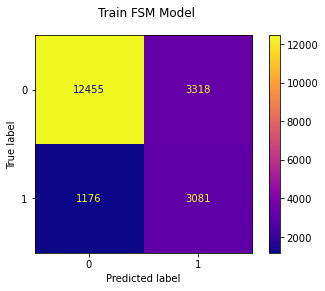

In [47]:
# confusion matrix
fig, ax = plt.subplots()
fig.suptitle('Train FSM Model')
plot_confusion_matrix(fsm_pipe, X_train, y_train, ax=ax, cmap='plasma');

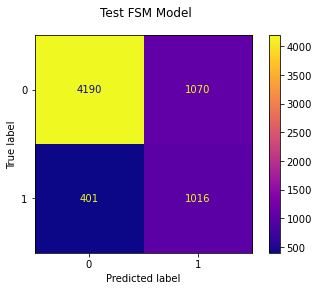

In [48]:
fig, ax = plt.subplots()
fig.suptitle('Test FSM Model')
plot_confusion_matrix(fsm_pipe, X_test, y_test, ax=ax, cmap='plasma');

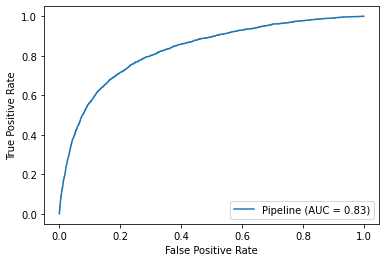

In [49]:
# roc curve
plot_roc_curve(fsm_pipe, X_train, y_train);

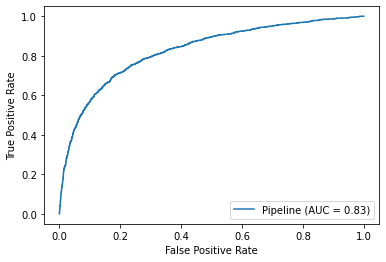

In [50]:
plot_roc_curve(fsm_pipe, X_test, y_test);

Ok so: we have a logistic regression model as our first simple model with 78% accuracy, 48% precision, 72% recall, and 58% fl score. 

### First Simple Model Hyperparameter Tuning

Let's first pick the parameters we want to play with. 

In [51]:
fsm_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ct', 'sm', 'fsm', 'ct__n_jobs', 'ct__remainder', 'ct__sparse_threshold', 'ct__transformer_weights', 'ct__transformers', 'ct__verbose', 'ct__bin_pipe', 'ct__ord_pipe', 'ct__cat_pipe', 'ct__bin_pipe__memory', 'ct__bin_pipe__steps', 'ct__bin_pipe__verbose', 'ct__bin_pipe__bin_impute', 'ct__bin_pipe__bin_impute__add_indicator', 'ct__bin_pipe__bin_impute__copy', 'ct__bin_pipe__bin_impute__fill_value', 'ct__bin_pipe__bin_impute__missing_values', 'ct__bin_pipe__bin_impute__strategy', 'ct__bin_pipe__bin_impute__verbose', 'ct__ord_pipe__memory', 'ct__ord_pipe__steps', 'ct__ord_pipe__verbose', 'ct__ord_pipe__ord_impute', 'ct__ord_pipe__ord_impute__add_indicator', 'ct__ord_pipe__ord_impute__copy', 'ct__ord_pipe__ord_impute__fill_value', 'ct__ord_pipe__ord_impute__missing_values', 'ct__ord_pipe__ord_impute__strategy', 'ct__ord_pipe__ord_impute__verbose', 'ct__cat_pipe__memory', 'ct__cat_pipe__steps', 'ct__cat_pipe__verbose', 'ct__cat_pipe__cat_impute', 'ct

In [56]:
# want bin impute strategy, ord impute strategy, cat impute strategy
# imputer strategy, I think most_frequent makes the most sense since the numericals are all binary/ordinal
# using mean or median etc. doesn't make much sense
# I didn't specify anything for the logistic regression model, so let's look at a few

params = {
    'fsm__solver' : ['liblinear', 'lbfgs'], 
    'fsm__max_iter': [10, 100,1000,10_000],
    'fsm__C' : [0.0001, 0.001, 0.01, 0.1, 1],
    'fsm__tol' : [0.0001, 0.001, 0.01, 0.1]    
}

In [57]:
gs = GridSearchCV(
    estimator = fsm_pipe,
    param_grid = params, 
    cv = 5, 
    verbose = 1
)

In [ ]:
# ran at 6:13 done by 641, forgot to check after 630

In [58]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A col

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Incr

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Incr

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Incr

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('bin_pipe',
                                                                         Pipeline(steps=[('bin_impute',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['behavioral_antiviral_meds',
                                                                          'behavioral_avoidance',
                                                                          'behavioral_face_mask',
                                                                          'behavioral_wash_hands',
                                                                          'behavioral_large_gatherings',
                                                                          'behavioral_outside_home',
        

In [61]:
params

{'fsm__solver': ['liblinear', 'lbfgs'],
 'fsm__max_iter': [10, 100, 1000, 10000],
 'fsm__C': [0.0001, 0.001, 0.01, 0.1, 1],
 'fsm__tol': [0.0001, 0.001, 0.01, 0.1]}

In [62]:
gs.best_params_

{'fsm__C': 0.1,
 'fsm__max_iter': 10,
 'fsm__solver': 'liblinear',
 'fsm__tol': 0.1}

For the best parameters, the solver is probably fine. Max_iter is 10, which is all the way to the left of the range, which is kind of interesting since I've been getting "increase your max iter" warnings. Fsm_tol is 0.1, which is all the way to the right of the range. 

Let's see how these results do, and then try adjusting the parameters (lowering the max_iter range and increasing the fsm_tol range). 

In [63]:
gs_best = gs.best_estimator_

In [74]:
gs_pipe = ModelWithCV(
    model=gs_best, 
    model_name='gs',
    X=X_train, 
    y=y_train.values.ravel()
)

In [75]:
# save the results in a dataframe so we can look at them later
gs_best_df = pd.DataFrame.from_dict(gs.cv_results_, orient='columns')
gs_best_df.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fsm__C,param_fsm__max_iter,param_fsm__solver,param_fsm__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.963126,0.027781,0.015124,0.001801,0.0001,10,liblinear,0.0001,"{'fsm__C': 0.0001, 'fsm__max_iter': 10, 'fsm__...",0.663505,0.654768,0.64653,0.669246,0.658762,0.658562,0.007717,153
1,0.987110,0.057184,0.012056,0.000545,0.0001,10,liblinear,0.001,"{'fsm__C': 0.0001, 'fsm__max_iter': 10, 'fsm__...",0.663754,0.654768,0.64653,0.669246,0.658762,0.658612,0.007750,149


In [76]:
gs_best.score(X_train, y_train)

0.7767848227658513

In [77]:
gs_best.score(X_test, y_test)

0.77894263890969

In [78]:
gs_best_train_pred = gs_best.predict(X_train)
gs_best_test_pred = gs_best.predict(X_test)

print(f"train accuracy: {round(accuracy_score(y_train, gs_best_train_pred),4)}")
print(f"train precision: {round(precision_score(y_train, gs_best_train_pred),4)}")
print(f"train recall: {round(recall_score(y_train, gs_best_train_pred),4)}")
print(f"train f1: {round(f1_score(y_train, gs_best_train_pred),4)}")
print(f"\n")
print(f"test accuracy: {round(accuracy_score(y_test, gs_best_test_pred),4)}")
print(f"test precision: {round(precision_score(y_test, gs_best_test_pred),4)}")
print(f"test recall: {round(recall_score(y_test, gs_best_test_pred),4)}")
print(f"test f1: {round(f1_score(y_test, gs_best_test_pred),4)}")

train accuracy: 0.7768
train precision: 0.4832
train recall: 0.7209
train f1: 0.5786


test accuracy: 0.7789
test precision: 0.4858
test recall: 0.7121
test f1: 0.5776


Ok so our model actually did worse?

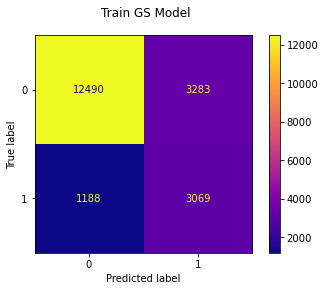

In [81]:
# confusion matrix
fig, ax = plt.subplots()
fig.suptitle('Train GS Model')
plot_confusion_matrix(gs_best, X_train, y_train, ax=ax, cmap='plasma');

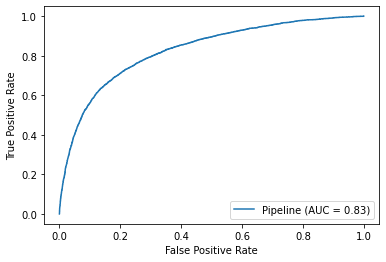

In [82]:
plot_roc_curve(gs_best, X_train, y_train);